In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

from distribution import gini, gamma

In [57]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

class PotentialCriminal(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = model.wealth_arr[unique_id]
        self.criminal = False
        
    def step(self): 
        if self.criminal:  
            return

        other_agent = self.random.choice(self.model.schedule.agents)

        if other_agent.wealth - self.wealth > self.model.deterrence:
            self.criminal = True

            stolen_amount = self.random.uniform(*self.model.fraction_stolen) * other_agent.wealth
            self.wealth += stolen_amount 
            other_agent.wealth -= stolen_amount
        
        return

def get_crime_rate(model):
    agent_out = [agent.criminal for agent in model.schedule.agents]
    return sum(agent_out)/model.num_agents

def get_gini(model):
    return gini(model.wealth_arr, plot=False)
    

class CrimeModel(Model):
    def __init__(self, N, deterrence, wealth_arr, fraction_stolen):
        self.num_agents = N
        self.deterrence = deterrence
        self.wealth_arr = wealth_arr
        self.fraction_stolen = fraction_stolen
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Crime rate": get_crime_rate,
                             "Gini Coefficient": get_gini
                             },
            agent_reporters={"Criminal": "criminal"}
        )
        
        for i in range(self.num_agents):
            a = PotentialCriminal(i, self)
            self.schedule.add(a)
    
    def crime_rate(self):
        return sum([a.criminal for a in self.schedule.agents])/self.num_agents
    
    def update_wealth_arr(self):
        self.wealth_arr = np.array([a.wealth for a in self.schedule.agents])
            
    def step(self):
        self.datacollector.collect(self)
        self.update_wealth_arr()
        self.schedule.step()

In [131]:
parameters = {
    "N": [100],
    "deterrence": [0.01, 0.1, 0.5],
    "gamma_alpha": [1, 2, 10],
    "gamma_beta": [1, 2, 10],
    "steps": [100],
    "distribution": ["gamma"],
    "fraction_stolen": [(0, 0.5)]
}
    

In [132]:
# create combinations of parameters
param_names = list(parameters.keys())
param_combinations = list(itertools.product(*[parameters[param] for param in param_names]))

results = []
counter = 0

for combination in param_combinations:  
    counter += 1
    print(f"Combination {counter}/{len(param_combinations)} \n"
            f"Parameters: {dict(zip(param_names, combination))}")
    # initialize parameters
    param_dict = dict(zip(param_names, combination))
    N = param_dict["N"]
    deterrence = param_dict["deterrence"]
    gamma_alpha = param_dict["gamma_alpha"]
    gamma_beta = param_dict["gamma_beta"]
    steps = param_dict["steps"]
    distribution = param_dict["distribution"]
    fraction_stolen = param_dict["fraction_stolen"]
    
    # create distribution
    wealth_arr = gamma(gamma_alpha, gamma_beta, N, plot=False)
    
    # create model
    model = CrimeModel(N, deterrence, wealth_arr, fraction_stolen)
    while model.schedule.steps < steps:
        model.step()
    
    # get data    
    model_df = model.datacollector.get_model_vars_dataframe()
    agent_df = model.datacollector.get_agent_vars_dataframe()
       
    # add data to results df
    results.append({
        "N": N,
        "deterrence": deterrence,
        "gamma_alpha": gamma_alpha,
        "gamma_beta": gamma_beta,
        "steps": steps,
        "distribution": distribution,
        "fraction_stolen": fraction_stolen,
        "gini_start": model_df['Gini Coefficient'].values[0],
        "gini_end": model_df['Gini Coefficient'].values[-1],
        "crime_rate": model_df['Crime rate'].values[-1],
        "wealth_arr_start": wealth_arr,
        "wealth_arr_end": model.wealth_arr,
        "gini_over_time": model_df['Gini Coefficient'].values.tolist(),  
        "crime_rate_over_time": model_df['Crime rate'].values.tolist()
    })
    
df_results = pd.DataFrame(results) 

fig, axs = plt.subplots(1, len(param_names), figsize=(15,5))
for param in param_names:
    for idx, param in enumerate(param_names):
        df_results.boxplot(column='crime_rate', by=param, ax=axs[idx])
        axs[idx].set_title('')
        axs[idx].set_xlabel(param)
        axs[idx].set_ylabel('Crime rate')
        
plt.suptitle('Crime rate by parameter')
plt.tight_layout
plt.show()

Combination 1/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 1, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 2/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 1, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 3/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 1, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 4/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 2, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 5/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 2, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 6/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 2, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 7/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 10, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 8/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 10, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 9/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 10, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 10/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 1, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 11/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 1, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 12/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 1, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 13/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 2, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 14/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 2, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 15/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 2, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 16/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 10, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 17/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 10, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 18/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 10, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 19/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 1, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 20/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 1, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 21/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 1, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 22/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 2, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 23/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 2, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 24/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 2, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 25/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 10, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 26/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 10, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 27/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 10, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23248\4102767916.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


In [127]:
# df_sim1 = df_results
# df_sim1

,N,deterrence,gamma_alpha,gamma_beta,steps,distribution,fraction_stolen,gini_start,gini_end,crime_rate,wealth_arr_start,wealth_arr_end,gini_over_time,crime_rate_over_time
0,100,0.0,1,1,100,gamma,"(0, 0.5)",0.523248,0.437299,0.99,"[0.002937004204846902, 0.0035521181386460004, ...","[0.017553493903190713, 0.005717993968902905, 0...","[0.5232484027599869, 0.5232484027599869, 0.475...","[0.0, 0.5, 0.65, 0.78, 0.84, 0.88, 0.89, 0.91,..."
1,100,0.0,1,1,100,gamma,"(0, 0.1)",0.473513,0.428303,0.99,"[0.007304938455796842, 0.014177126584500613, 0...","[0.0023940552117314496, 0.03170400679839733, 0...","[0.473512506184001, 0.473512506184001, 0.44659...","[0.0, 0.52, 0.65, 0.76, 0.78, 0.83, 0.84, 0.87..."
2,100,0.0,1,1,100,gamma,"(0, 0.9)",0.496737,0.439433,1.00,"[0.006389022398179788, 0.011536023565169595, 0...","[0.003354670669476891, 0.014367321760911779, 0...","[0.4967372741914927, 0.4967372741914927, 0.446...","[0.0, 0.49, 0.75, 0.89, 0.94, 0.97, 0.97, 0.97..."
3,100,0.0,1,1,100,gamma,"(0.5, 0.1)",0.530174,0.397601,0.99,"[0.012143694909314717, 0.001484617523571689, 0...","[0.004191670486952938, 0.008419626268498263, 0...","[0.5301741947343646, 0.5301741947343646, 0.431...","[0.0, 0.57, 0.75, 0.81, 0.88, 0.91, 0.92, 0.95..."
4,100,0.0,1,1,100,gamma,"(0.5, 0.5)",0.525901,0.374903,1.00,"[0.0033644391303810604, 0.011831776337337238, ...","[0.003913686226310275, 0.0017254239189386598, ...","[0.5259009392854175, 0.5259009392854175, 0.411...","[0.0, 0.53, 0.82, 0.9, 0.93, 0.94, 0.97, 0.97,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,200,0.5,10,100,100,gamma,"(0, 0.5)",0.167393,0.167393,0.00,"[0.004543199302947636, 0.0069549209157323075, ...","[0.0030529838465947977, 0.0046013367834390586,...","[0.16739273725215797, 0.16739273725215797, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
356,200,0.5,10,100,100,gamma,"(0, 0.1)",0.183013,0.183013,0.00,"[0.0027655081552258546, 0.0072431625612687945,...","[0.004721355510992982, 0.0035433255750393034, ...","[0.18301332246899582, 0.18301332246899582, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
357,200,0.5,10,100,100,gamma,"(0, 0.9)",0.177604,0.177604,0.00,"[0.005453501729857404, 0.003477982233029346, 0...","[0.00408506918833257, 0.006337361556683528, 0....","[0.17760375672985496, 0.17760375672985496, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
358,200,0.5,10,100,100,gamma,"(0.5, 0.1)",0.182755,0.182755,0.00,"[0.0029731155094776455, 0.008729312728608996, ...","[0.0052115172865726846, 0.0038080169530902395,...","[0.18275524705227542, 0.18275524705227542, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [133]:
df_sim2 = df_results
df_sim2

,N,deterrence,gamma_alpha,gamma_beta,steps,distribution,fraction_stolen,gini_start,gini_end,crime_rate,wealth_arr_start,wealth_arr_end,gini_over_time,crime_rate_over_time
0,100,0.01,1,1,100,gamma,"(0, 0.5)",0.521241,0.245974,0.80,"[0.0059413087940024594, 0.0059747704589497705,...","[0.014856344418972671, 0.006762352027201893, 0...","[0.5212410790326818, 0.5212410790326818, 0.418...","[0.0, 0.3, 0.38, 0.48, 0.55, 0.59, 0.61, 0.62,..."
1,100,0.01,1,2,100,gamma,"(0, 0.5)",0.496493,0.268244,0.78,"[0.0030189530442150674, 0.003112451840687439, ...","[0.007952258573945721, 0.009793928627013664, 0...","[0.49649284049997666, 0.49649284049997666, 0.4...","[0.0, 0.18, 0.35, 0.43, 0.5, 0.51, 0.55, 0.59,..."
2,100,0.01,1,10,100,gamma,"(0, 0.5)",0.525904,0.219940,0.81,"[0.03200754996479647, 0.02924368932324178, 0.0...","[0.011310386358717874, 0.01464489064690749, 0....","[0.5259039275486714, 0.5259039275486714, 0.477...","[0.0, 0.12, 0.3, 0.42, 0.49, 0.56, 0.59, 0.63,..."
3,100,0.01,2,1,100,gamma,"(0, 0.5)",0.346292,0.156289,0.48,"[0.008258670451171188, 0.0077748756330725975, ...","[0.006545245405443046, 0.010168441239964729, 0...","[0.346292400235402, 0.346292400235402, 0.32702...","[0.0, 0.06, 0.16, 0.25, 0.3, 0.32, 0.34, 0.35,..."
4,100,0.01,2,2,100,gamma,"(0, 0.5)",0.400242,0.189418,0.62,"[0.007148554101270452, 0.0027075705857080887, ...","[0.007938238426987989, 0.013787209223467024, 0...","[0.4002417969624298, 0.4002417969624298, 0.359...","[0.0, 0.14, 0.27, 0.31, 0.36, 0.39, 0.44, 0.49..."
5,100,0.01,2,10,100,gamma,"(0, 0.5)",0.390741,0.169869,0.55,"[0.01236232292805726, 0.006180813734266875, 0....","[0.008867607745085247, 0.007246723639432108, 0...","[0.3907406728224375, 0.3907406728224375, 0.322...","[0.0, 0.2, 0.3, 0.32, 0.35, 0.35, 0.36, 0.38, ..."
6,100,0.01,10,1,100,gamma,"(0, 0.5)",0.174607,0.135006,0.12,"[0.00940040745021873, 0.009446955040927948, 0....","[0.011815379873111601, 0.009551494642480387, 0...","[0.1746074476204077, 0.1746074476204077, 0.172...","[0.0, 0.01, 0.03, 0.04, 0.06, 0.06, 0.06, 0.06..."
7,100,0.01,10,2,100,gamma,"(0, 0.5)",0.182822,0.140909,0.12,"[0.009214678010440831, 0.006289832424754362, 0...","[0.006193596844356245, 0.014369290745462154, 0...","[0.18282174616058133, 0.18282174616058133, 0.1...","[0.0, 0.01, 0.04, 0.07, 0.07, 0.07, 0.07, 0.09..."
8,100,0.01,10,10,100,gamma,"(0, 0.5)",0.170978,0.132785,0.09,"[0.007744867319178193, 0.007835449459300613, 0...","[0.007568440086545678, 0.008984129235328457, 0...","[0.17097778020825694, 0.17097778020825694, 0.1...","[0.0, 0.01, 0.01, 0.02, 0.03, 0.05, 0.05, 0.05..."
9,100,0.10,1,1,100,gamma,"(0, 0.5)",0.494745,0.494745,0.00,"[0.002484040030192323, 0.0375310869283283, 0.0...","[0.01268130201151641, 0.0022451647759134884, 0...","[0.49474541191661237, 0.49474541191661237, 0.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [129]:
def model_plots(df, idx):
    # Convert lists back to arrays
    gini_over_time = np.array(df.loc[idx, 'gini_over_time'])
    crime_rate_over_time = np.array(df.loc[idx, 'crime_rate_over_time'])
    wealth_arr_start = np.array(df.loc[idx, 'wealth_arr_start'])
    wealth_arr_end = np.array(df.loc[idx, 'wealth_arr_end'])

    fig, axs = plt.subplots(2,2, figsize=(10,10))
    axs[0,0].plot(gini_over_time)
    axs[0,0].set_title("Gini Coefficient over time")

    axs[0,1].plot(crime_rate_over_time)
    axs[0,1].set_title("Crime rate over time")

    axs[1,0].hist(wealth_arr_start, bins=50)
    axs[1,0].set_title(f"Wealth distribution start, Gini coefficient = {df.loc[idx, 'gini_start']:.2f}")

    axs[1,1].hist(wealth_arr_end, bins=50)
    axs[1,1].set_title(f"Wealth distribution end, Gini coefficient = {df.loc[idx, 'gini_end']:.2f}")
    
    fig.suptitle (f"N: N = {N} \n"
              f"deterrence = {deterrence} \n"
              f"gamma_alpha = {gamma_alpha}\n"
              f" gamma_beta = {gamma_beta}\n"
              f"steps = {steps}\n"
              f" distribution = {distribution}\n"
              f"fraction_stolen = {fraction_stolen}")
        
    plt.tight_layout()
    plt.show()

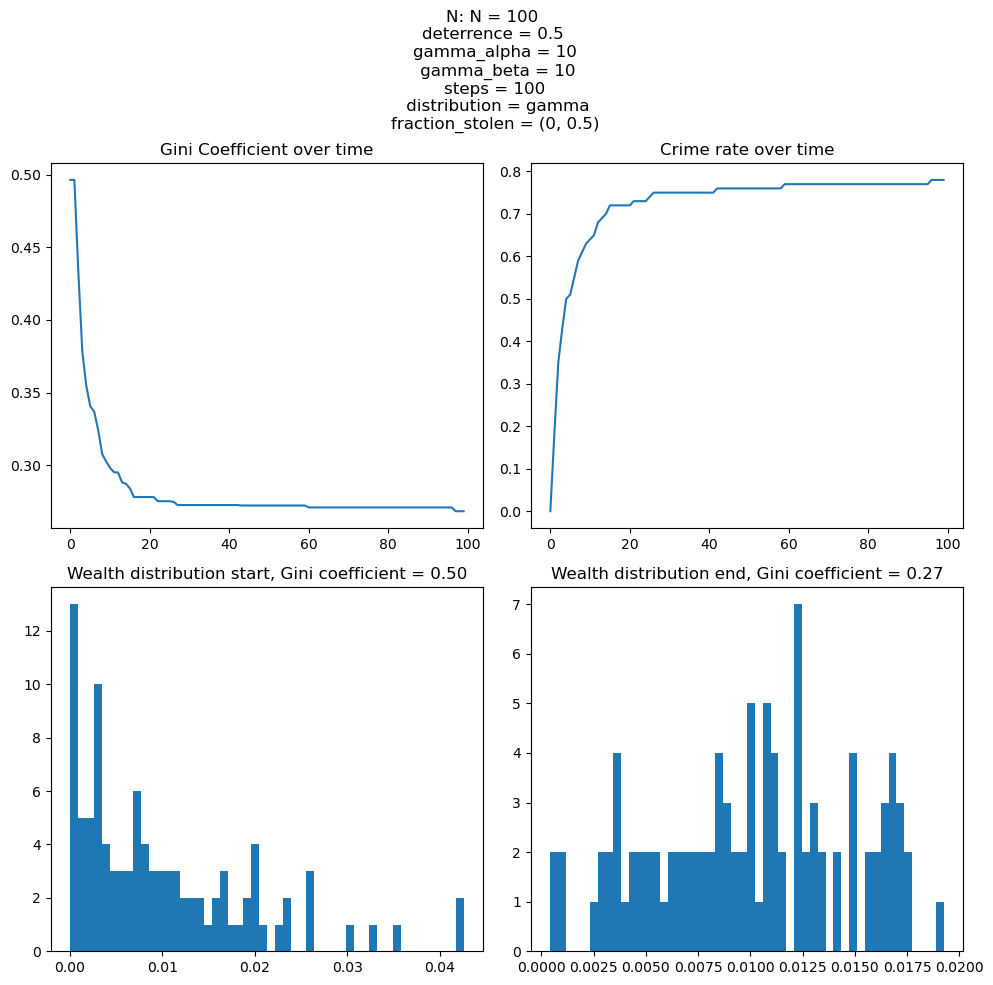

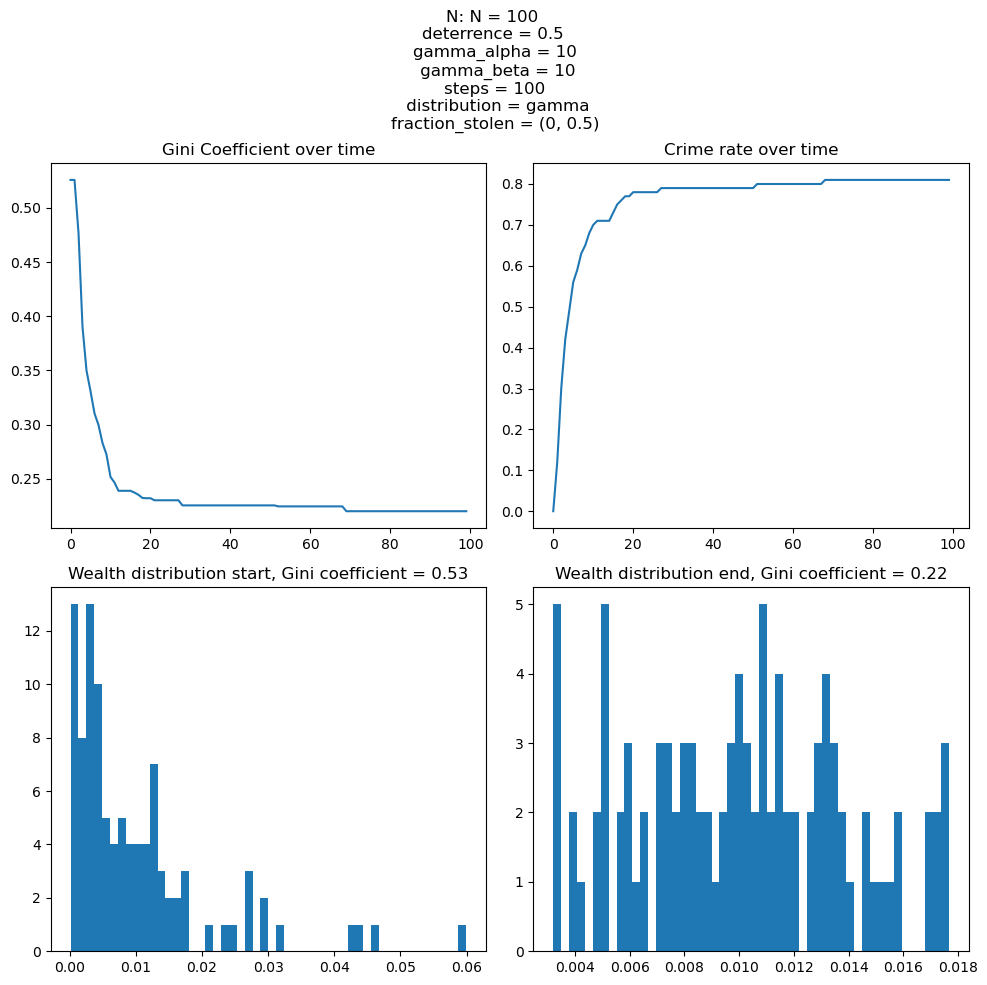

In [134]:
for idx in [1,2]:
    model_plots(df_sim2, idx)

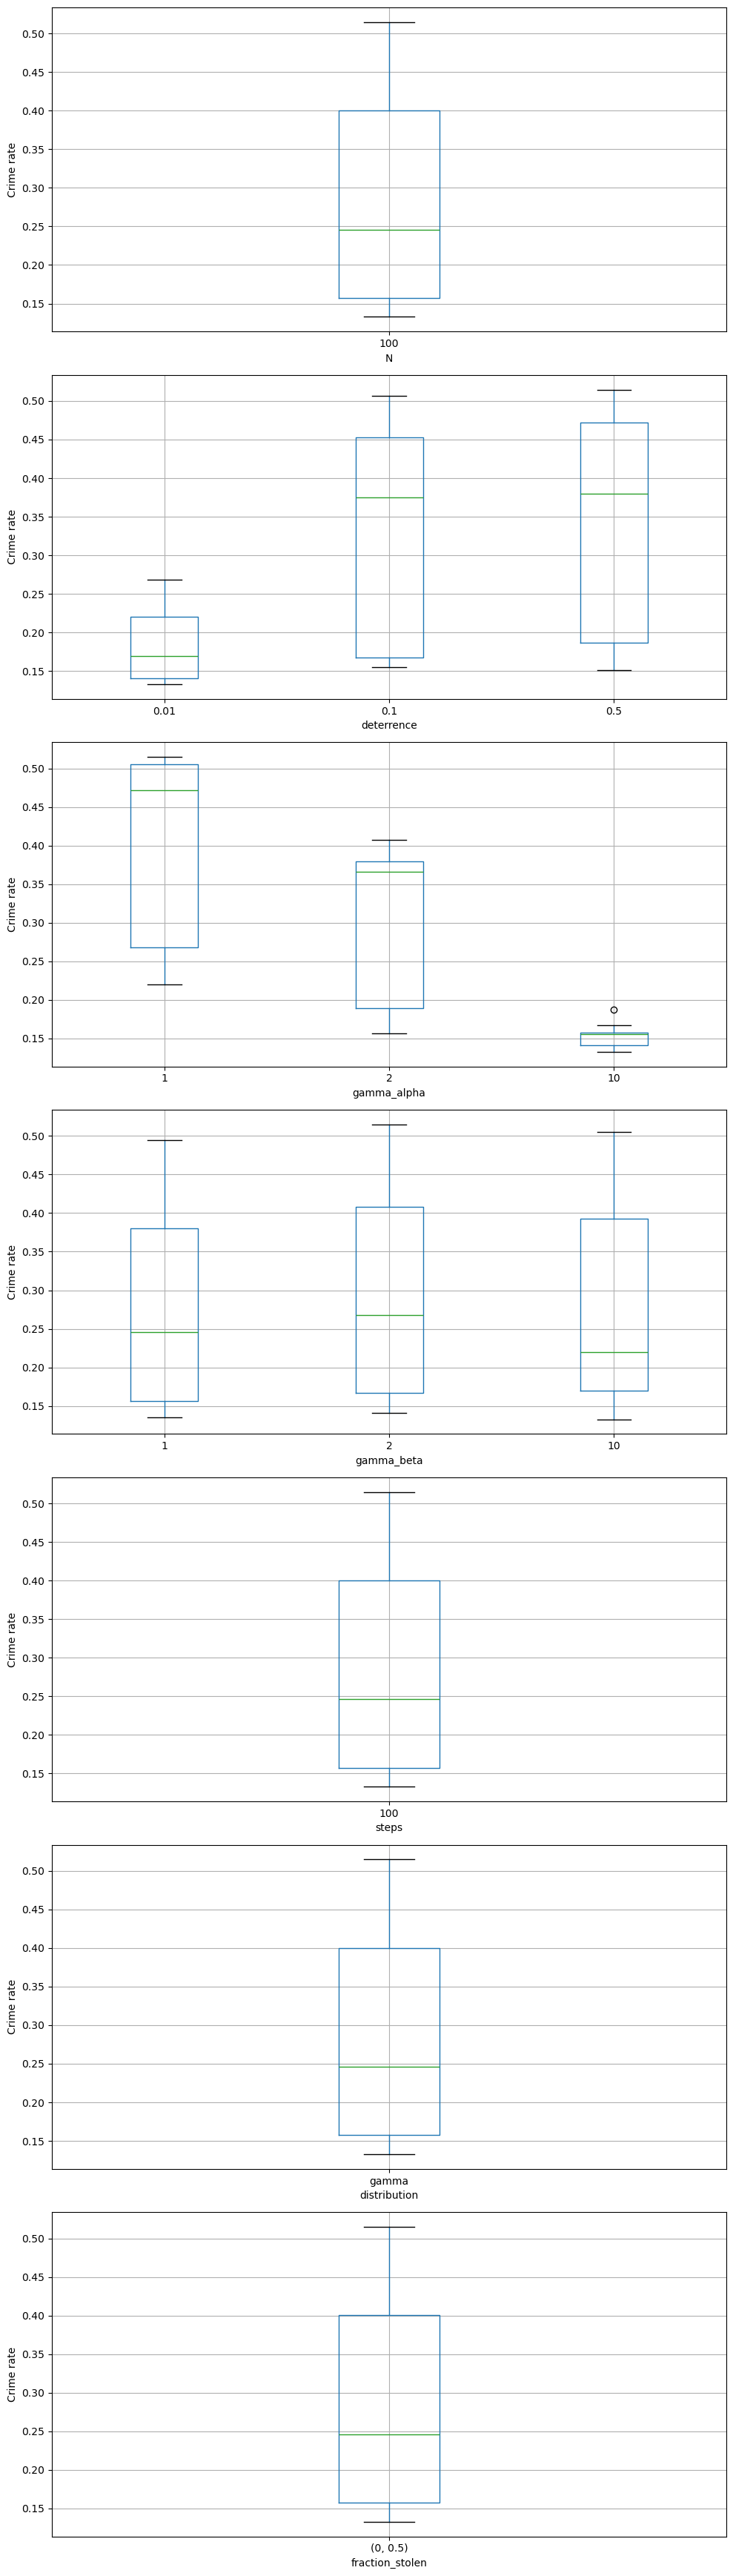